## Import Dependencies

In [252]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np

# Loading Dataset

In [253]:
dataset, dataset_info = tfds.load("malaria", with_info=True, shuffle_files=True, as_supervised=True, split=['train'])

In [254]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [255]:
def splits(dataset, train_ratio, val_ratio, test_ratio):
    DATASET_SIZE = len(dataset)
    
    train_dataset = dataset.take(int(train_ratio * DATASET_SIZE))

    val_test_dataset = dataset.skip(int(train_ratio * DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(val_ratio * DATASET_SIZE))

    test_dataset = val_test_dataset.skip(int(test_ratio*DATASET_SIZE))
    
    return train_dataset, val_dataset, test_dataset

In [256]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# Data Visualization

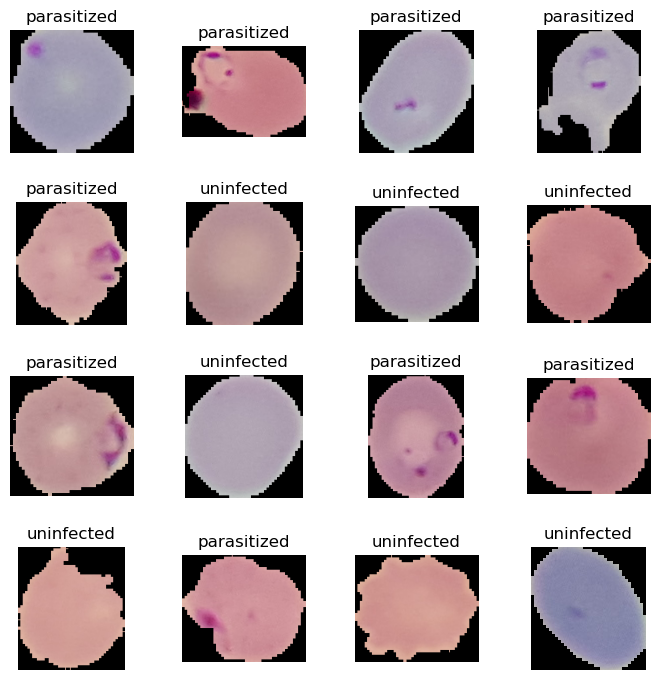

In [257]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

# Iterate over the first 16 elements in the train_dataset
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis("off")
    
# Show the plot
plt.show()

# Data Augmentation Visualization

In [258]:
def visualize(original, augmented):
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    
    plt.subplot(1, 2, 2)
    plt.imshow(augmented)

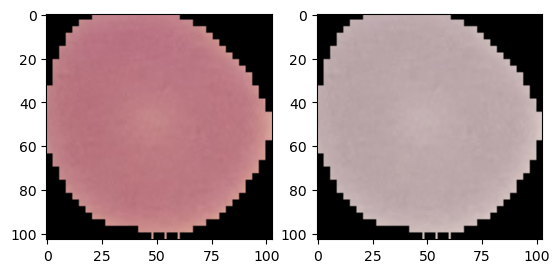

In [259]:
original_image, label = next(iter(train_dataset))

# augmented_image = tf.image.flip_left_right(original_image)
# augmented_image = tf.image.random_flip_up_down(original_image)
# augmented_image = tf.image.rot90(original_image)
# augmented_image = tf.image.adjust_brightness(original_image, -0.4)
# augmented_image = tf.image.random_brightness(original_image, 1)
# augmented_image = tf.image.random_saturation(original_image, lower=2, upper=12)
# augmented_image = tf.image.central_crop(original_image, 0.8)
augmented_image = tf.image.adjust_saturation(original_image, saturation_factor=0.3)

visualize(original_image, augmented_image)

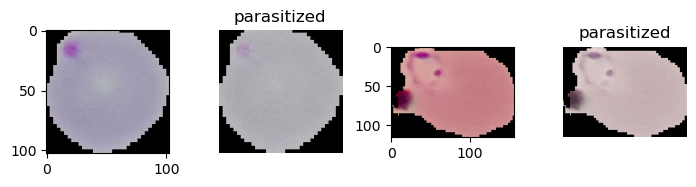

In [260]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

# Iterate over the first 2 elements in the train_dataset
for i, (image, label) in enumerate(train_dataset.take(2)):
    plt.subplot(1, 4, 2*i + 1)
    plt.imshow(image)
    
    plt.subplot(1, 4, 2*i + 2)
    plt.imshow(tf.image.adjust_saturation(image, 0.3))

    plt.title(dataset_info.features["label"].int2str(label))
    plt.axis("off")
    
# Show the plot
plt.show()

# Data Preprocessing

In [261]:
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0, label

In [262]:
from tensorflow.keras.layers import Layer

class RotNinety(Layer):
    def __ini__(self):
        super().__init__()
    
    def call(self, image):
        return tf.image.rot90(image)

In [263]:
### tf.image augment
def augment(image, label):
    
    image, label = resize_rescale(image, label)
    image = tf.image.rot90(image)
    # image = tf.image.adjust_saturation(image, saturation_factor=0.3)
    image = tf.image.flip_left_right(image)
    
    return image, label

In [264]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, Resizing, Rescaling

### tf.keras.layer resizing and rescaling
resize_rescale_layers = tf.keras.Sequential()
resize_rescale_layers.add(Resizing(IM_SIZE, IM_SIZE))
resize_rescale_layers.add(Rescaling(1.0/255))

### tf.keras.layer augment
augment_layers = tf.keras.Sequential()
augment_layers.add(RotNinety())
augment_layers.add(RandomFlip(mode="horizontal"))

def augment_layer(image, label):
    augmented_image = resize_rescale_layers(image)
    augmented_image = augment_layers(augmented_image, training=True)
    return augmented_image, label

In [265]:
test_dataset = test_dataset.map(resize_rescale_layers)

In [266]:
BATCH_SIZE = 32

In [267]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True)
train_dataset = train_dataset.map(augment_layer)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [268]:
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True)
val_dataset = val_dataset.map(augment_layer)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [269]:
# original_image, label = next(iter(train_dataset))

# augmented_image = tf.image.flip_left_right(original_image)

# # original_image
# visualize(original_image, augmented_image)

# Model Creation

In [270]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [271]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Dropout
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.metrics import Accuracy, FalseNegatives, FalsePositives, TruePositives, TrueNegatives, Precision, Recall, BinaryAccuracy, AUC
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import CSVLogger

In [272]:
dropout_rate = 0.3
regularization_rate = 0.01

In [273]:
lenet_model = tf.keras.Sequential()

lenet_model.add(InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)))

# lenet_model.add(resize_rescale_layers)
# lenet_model.add(augment_layers)

lenet_model.add(Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu", kernel_regularizer=L2(regularization_rate)))
lenet_model.add(BatchNormalization())
lenet_model.add(MaxPool2D(pool_size=2, strides=2))
lenet_model.add(Dropout(rate=dropout_rate))

lenet_model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu", kernel_regularizer=L2(regularization_rate)))
lenet_model.add(BatchNormalization())
lenet_model.add(MaxPool2D(pool_size=2, strides=2))

lenet_model.add(Flatten())

lenet_model.add(Dense(100, activation="relu", kernel_regularizer=L2(regularization_rate)))
lenet_model.add(BatchNormalization())
lenet_model.add(Dropout(rate=dropout_rate))

lenet_model.add(Dense(10, activation="relu", kernel_regularizer=L2(regularization_rate)))
lenet_model.add(BatchNormalization())
lenet_model.add(Dense(1, activation="sigmoid"))

lenet_model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_24 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 111, 111, 6)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_25 (Bat  (None, 109, 109, 16)   

In [274]:
metrics = [
    TruePositives(name="True Positives"),
    TrueNegatives(name="True Negatives"),
    FalseNegatives(name="False Negatives"),
    FalsePositives(name="False Positives"),
    BinaryAccuracy(name="Binary Accuracy"),
    Precision(name="Precision"),
    Recall(name="Recall"),
    AUC(name="AUC"),
    "accuracy",
]

In [275]:
csv_callback = CSVLogger('logs.csv', separator=',', append=True)

callbacks = [
    csv_callback
]

In [276]:
lenet_model.compile(optimizer=Adam(learning_rate=0.01),
                   loss=BinaryCrossentropy(),
                   metrics=metrics,
                   run_eagerly=False)

In [277]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1) #  callbacks=callbacks

Epoch 1/5
689/689 [==============================] - 36s 50ms/step - loss: 3.9471 - True Positives: 9133.0000 - True Negatives: 8291.0000 - False Negatives: 1889.0000 - False Positives: 2733.0000 - Binary Accuracy: 0.7903 - Precision: 0.7697 - Recall: 0.8286 - AUC: 0.8569 - accuracy: 0.7903 - val_loss: 3.0134 - val_True Positives: 1379.0000 - val_True Negatives: 647.0000 - val_False Negatives: 8.0000 - val_False Positives: 721.0000 - val_Binary Accuracy: 0.7354 - val_Precision: 0.6567 - val_Recall: 0.9942 - val_AUC: 0.8695 - val_accuracy: 0.7354
Epoch 2/5
689/689 [==============================] - 38s 55ms/step - loss: 4.0287 - True Positives: 10447.0000 - True Negatives: 8807.0000 - False Negatives: 576.0000 - False Positives: 2216.0000 - Binary Accuracy: 0.8734 - Precision: 0.8250 - Recall: 0.9477 - AUC: 0.9062 - accuracy: 0.8734 - val_loss: 4.7334 - val_True Positives: 66.0000 - val_True Negatives: 1349.0000 - val_False Negatives: 1321.0000 - val_False Positives: 19.0000 - val_Binar

# Plot out performance

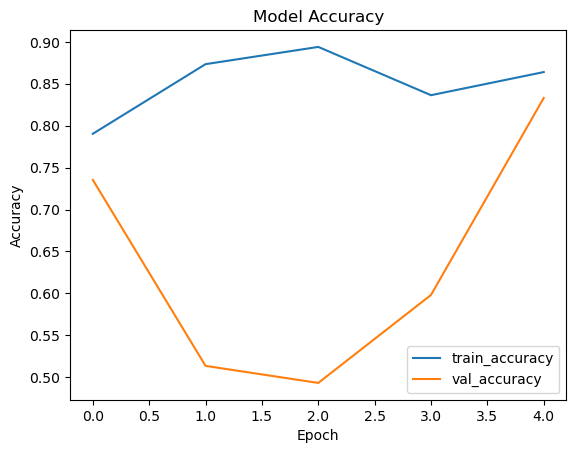

In [278]:
plt.plot(history.history['accuracy'])
plt.plot(history.history["val_accuracy"])

plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation

In [279]:
import cv2

In [280]:
batch_1_test_dataset = test_dataset.batch(1)
batch_1_test_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [281]:
model_prediction = lenet_model.predict(batch_1_test_dataset.take(1))
model_prediction

array([[0.8946942]], dtype=float32)

In [282]:
def parasite_or_not(x):
    if (x < 0.5):
        return 'Parasatize'
    return 'Uninfected'

In [283]:
result = model_prediction[0][0]
parasite_or_not(result)

'Uninfected'

In [284]:
# fig = plt.figure(figsize=(8, 8))
# fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

# for i, (image, label) in enumerate(batch_1_test_dataset.take(9)):
    
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(image[0])
    
#     title = f"{parasite_or_not(label.numpy()[0])} : {parasite_or_not(lenet_model.predict(image)[0][0])}"
#     plt.title(title)
    
#     plt.axis("off")

In [285]:
image = cv2.imread("cell.png")
print(image.shape)

image = tf.expand_dims(image, axis=0)
print(image)

image = resize_rescale_layers(image)

(139, 160, 3)
tf.Tensor(
[[[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  ...

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]]], shape=(1, 139, 160, 3), dtype=uint8)


In [287]:
result = lenet_model.predict(image)
parasite_or_not(result)

'Parasatize'